In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Asynchronous Python', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Exchange Online and Defender,74.316271,1.905545,8.695589,39
Docker,201.572878,6.502351,15.112803,31
SSH + SCP,249.156669,8.591609,23.079328,29
GUI Docker Container,406.275210,19.346439,35.158779,21
Linux,674.767539,21.086486,34.591371,32
"Everything is Tuberculosis, Green",505.545659,21.980246,34.700696,23
WinHex,537.147642,25.578459,39.786827,21
"The Simulacra, Dick",773.470965,40.708998,69.756127,19
Windows PATH Variable,1323.683851,44.122795,94.621738,30
Node.JS and React,1846.852700,59.575894,151.599038,31


# Histogram

sum of ages: ~54657.82


<Axes: >

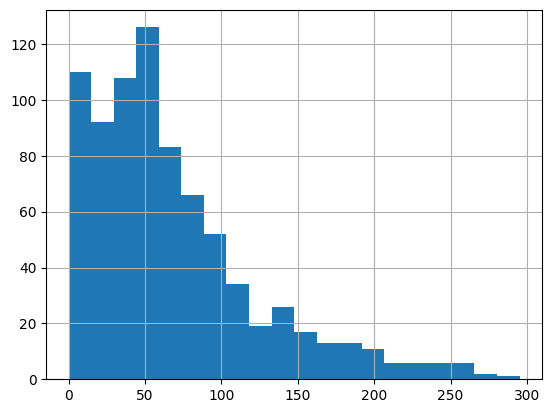

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54657.82


<Axes: >

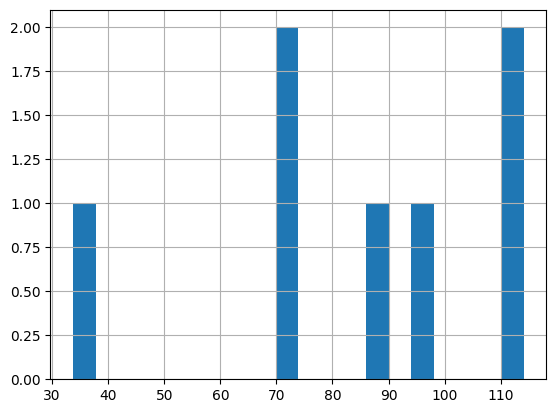

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='The Starless Crown, Rollins']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
n = 3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // m

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 797
Total card age: 54657.82


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
0,Python,Q:\nHow does the os.walk() function handle per...,5b22fe84dea3190c71ab1611317e290c,-259.174861,90.772197,259.174861,-6898.686991,0.785868,76,0,0
1,Python,"Q:\nHow can you use tqdm with file operations,...",70d79d8d31058fa7cb312f724aa1d578,-248.123757,90.772197,259.174861,-6898.686991,0.785868,76,1,0
2,Python,The purpose of the @contextmanager decorator i...,a65833f482a1a8368f63e575c4480675,-223.293817,90.772197,259.174861,-6898.686991,0.785868,76,2,0
3,Python,Q:\nHow can you disable the tqdm progress bar ...,af94a5eb6b43c2c8dcfdfa47653c75f4,-216.036292,90.772197,259.174861,-6898.686991,0.785868,76,3,0
5,Python,"Q:\nWhat is lazy evaluation, and how do genera...",2916065a4a1c2389fc0c4062909198ca,-196.068040,90.772197,259.174861,-6898.686991,0.785868,76,4,0
4,Python,Q:\nWhat does itertools.islice() do?\n\nA:\nIt...,add9aef3e23b8fbc5d5b583ccb095fa7,-195.695520,90.772197,259.174861,-6898.686991,0.785868,76,5,0
6,Python,How can you compare two Path objects for equal...,035f02d95c84e3abeaaf924efaa9a3a4,-189.136141,90.772197,259.174861,-6898.686991,0.785868,76,6,0
7,Azure Files Documentation,Quota is a limit on the size of the file share...,3bef1cf2ec625defd17ff26244de22f9,-278.072976,88.335921,278.072976,-5035.147496,0.555190,57,0,0
8,Azure Files Documentation,"Beginning with Windows Server 2025, Kerberos n...",638849920853268b36007e709ee4ee6c,-182.666273,88.335921,278.072976,-5035.147496,0.555190,57,1,0
9,Azure Files Documentation,NFS file shares are accessible from the storag...,5356926ab1c92e5a421b49e2110b9dce,-181.291140,88.335921,278.072976,-5035.147496,0.555190,57,2,0


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [26]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(-2169.55881914133)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
14,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,-295.170255,94.662425,295.170255,-3881.159440,0.054585,41,0,0
7,Azure Files Documentation,Quota is a limit on the size of the file share...,3bef1cf2ec625defd17ff26244de22f9,-278.072976,88.335921,278.072976,-5035.147496,0.555190,57,0,0
98,Accounting,Allowance Method for Doubtful Accounts\nEstima...,8ab1c9af408775b6a1a9bd2d0c649d14,-272.063711,95.728804,272.063711,-1531.660857,0.599961,16,0,0
112,PnP PowerShell,SharePoint CSOM (Client-Side Object Model)\nA ...,4e429af56cd1ace6b2032b1bc6474abc,-261.606217,128.862696,261.606217,-1417.489653,0.064503,11,0,0
21,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,-260.626926,84.616402,260.626926,-3807.738105,0.873707,45,0,0
99,Accounting,General Ledger (GL)\nCentral accounting record...,2e1cb1792a872ef7c0655341a20c8431,-260.453860,95.728804,272.063711,-1531.660857,0.599961,16,1,0
0,Python,Q:\nHow does the os.walk() function handle per...,5b22fe84dea3190c71ab1611317e290c,-259.174861,90.772197,259.174861,-6898.686991,0.785868,76,0,0
42,Django,Django App\nA self-contained feature module (e...,369de91dbb3f2242f251cc46ac43faac,-258.989530,79.424157,258.989530,-3176.966295,0.386725,40,0,0
113,PnP PowerShell,Invoke-PnPRequest (PnP.PowerShell)\nSends cust...,76b6b1815c89739010ffb02cb0d2d6fd,-251.354024,128.862696,261.606217,-1417.489653,0.064503,11,1,0
1,Python,"Q:\nHow can you use tqdm with file operations,...",70d79d8d31058fa7cb312f724aa1d578,-248.123757,90.772197,259.174861,-6898.686991,0.785868,76,1,0


In [30]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 68.579'